In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

main_directory = r'C:\Users\ASUS\Desktop\ML-data science\DataIncubator\yelp-cleaners' + '\\'
data_directory = main_directory + 'data' + '\\'
processed_data_directory = data_directory + r'processed data' + '\\'
model_directory = data_directory + r'models' + '\\'

In [2]:
import sklearn
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor, LogisticRegression
from sklearn import datasets, tree, utils
from sklearn import model_selection, ensemble
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.preprocessing import MinMaxScaler
from collections import Counter, OrderedDict
import math
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import pickle as pkl

In [3]:
from yelpapi import YelpAPI
# get yelp api key stored in txt file
f = open(data_directory + 'yelp_api_key.txt','r')
api_key = f.read()
f.close()

In [106]:
import spacy
# nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
STOP_WORDS = STOP_WORDS.union({'ll', 've'})
from sklearn.naive_bayes import MultinomialNB

# bag of words model

Regression is tricky with little data. Let's classify each inspection to the nearest 1, and try that.

In [5]:
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv')
# df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

In [6]:
yy = np.array(df['Score'])
print(f'{sum(yy%1 != 0.0)}/{len(yy)} ({sum(yy%1 != 0.0)/len(yy)*100}%) are fractional scores')

4184/570614 (0.7332452410911755%) are fractional scores


rounding each score to the ones digit only changes <1% of the scores. This shouldn't change much.

## build single review model

### feature engineering

In [116]:
# # let's just look at businesses with >100 reviews
# num_reviews = df.business_id.value_counts()
# valid_businesses = num_reviews[num_reviews >= 100].index
# df = df[df['business_id'].isin(valid_businesses)].reset_index(drop=True)

In [117]:
# # only look at outraged customers
# df = df[df.review_stars <= 3]

In [42]:
reviews = np.array(df['text'])
scores = np.array(df['Score'])
X, y = reviews, scores
# round
roundby = 1
y = np.array(list(map(lambda x: math.ceil(x / roundby) * roundby,y)))
# classify into two categories
# thresh = 80
# y = np.array(list(map(lambda x: 1 if x > thresh else 0, y)))

In [43]:
# simple bag of words
bow_vectorizer = TfidfVectorizer(min_df=10,
                                 max_df=0.5,
                                 max_features=20000,
                                 ngram_range=(1,2),
                                 stop_words=STOP_WORDS)
# svd = TruncatedSVD(n_components=100)
features = Pipeline([
    ('tfidf',bow_vectorizer),
    ('svd',TruncatedSVD(n_components=200)),
    ('minmax',MinMaxScaler(feature_range=(0,1))) # necessary for NB
])

In [44]:
# # looking at high tf-idf terms
# high_value_terms = dict(zip(features.named_steps.tfidf.vocabulary_, features.named_steps.tfidf.idf_))
# high_value_terms = dict(sorted(high_value_terms.items(), key=lambda item: item[1],reverse=False))
# high_value_terms

In [45]:
%%time
X_out = features.fit_transform(X,y)

Wall time: 5min 1s


In [46]:
X_out_shuff, y_shuff = shuffle(X_out, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_out_shuff, y_shuff, test_size=0.2)

In [175]:
# save to file
filename = model_directory + 'individual_review_features.pkl'
# pkl.dump(features, open(filename,'wb'))

make sure pickling worked

In [ ]:
filename = model_directory + 'individual_review_features.pkl'
loaded_features = pkl.load(open(filename, 'rb'))

In [177]:
X_out_2 = loaded_features.transform(X)

In [181]:
# they're the same, so pickling works
sum(sum(X_out - X_out_2))

-6.583995501574513e-13

### test different models

In [48]:
def test_regressor(regressor,print_R2=True,residual_hist=True,predictions_hist=True):
    regressor.fit(X_train,y_train)
    if print_R2:
        print(f'R^2 score: {regressor.score(X_test, y_test)}')
    y_predict = regressor.predict(X_test)
    if residual_hist:
        fig = plt.figure(1)
        plt.hist(y_predict-y_test,bins=30,alpha=0.5);
        plt.show()
    if predictions_hist:
        fig = plt.figure(2)
        plt.hist(y_predict,bins=30,alpha=0.5)
        plt.hist(y_test,bins=30,alpha=0.5)
        plt.show()

R^2 score: 0.1199595208057419


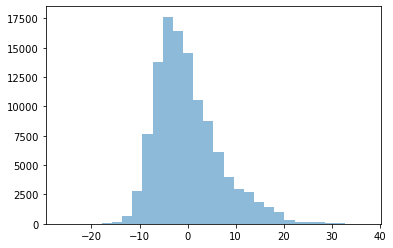

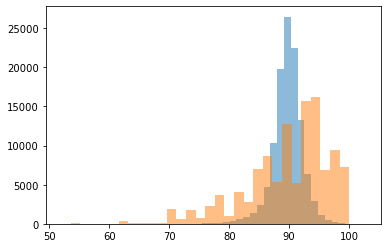

Wall time: 4.3 s


In [49]:
%%time
regressor = Ridge(alpha=10)
test_regressor(regressor)

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


R^2 score: 0.14601789297512333


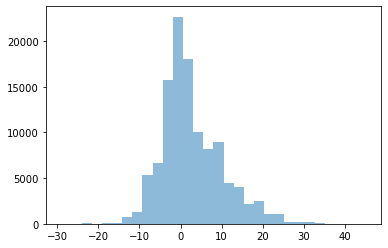

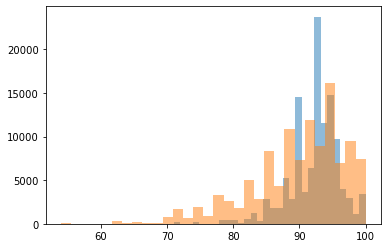

Wall time: 4min 19s


In [138]:
%%time
regressor = LogisticRegression(solver = 'lbfgs', max_iter=100)
test_regressor(regressor)

In [52]:
%%time
parameters = {
    'alpha': [0.01,0.1,1,10]
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

Wall time: 17.2 s


{'alpha': 10}

R^2 score: 0.0871341519711938


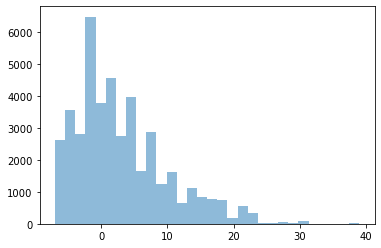

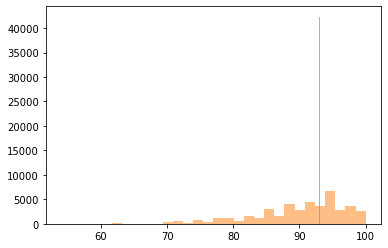

Wall time: 1.09 s


In [ ]:
# %%time
# regressor = MultinomialNB()
# test_regressor(regressor)

In [128]:
# priors = OrderedDict(sorted(Counter(y_test).items()))
# priors = np.fromiter(priors.values(), dtype=float)/len(y_test)

In [236]:
%%time
# regressor = GaussianNB(priors=priors, var_smoothing=0.8)
regressor = GaussianNB(var_smoothing=0.001)
test_regressor(regressor)

KeyboardInterrupt: 

In [233]:
regressor.score(X_out,y)

0.0961245255111161

In [234]:
from sklearn.metrics import r2_score
r2_score(y, regressor.predict(X_out))

-2.8772872852905915

In [132]:
%%time
parameters = {
    'var_smoothing': np.logspace(-9,1,11)
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Wall time: 4min 48s


{'var_smoothing': 0.001}

### Ridge

R^2 score: 0.1199595208057419


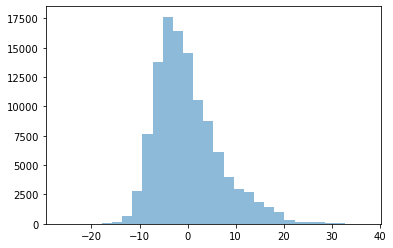

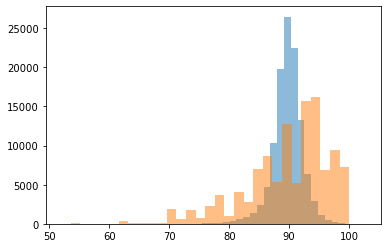

Wall time: 4.44 s


In [53]:
%%time
regressor = Ridge(alpha=10)
test_regressor(regressor)

In [54]:
regressor.score(X_out,y)

0.12217979451820682

In [55]:
from sklearn.metrics import r2_score
r2_score(y, regressor.predict(X_out))

0.12217979451820682

In [57]:
# sklearn.metrics.accuracy_score(y, regressor.predict(X_out))

In [58]:
filename = model_directory + 'individual_review_model_ridge.pkl'
pkl.dump(regressor, open(filename,'wb'))

### final model: logistic regression

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


R^2 score: 0.14867292307422694


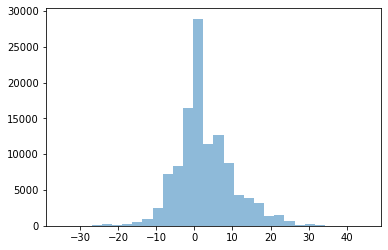

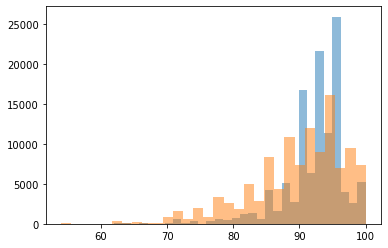

Wall time: 9h 6min 37s


In [139]:
%%time
regressor = LogisticRegression(solver = 'lbfgs', max_iter=500)
test_regressor(regressor)

In [153]:
filename = model_directory + 'individual_review_model.pkl'
# pkl.dump(regressor, open(filename,'wb'))

In [154]:
loaded_model = pkl.load(open(filename, 'rb'))

(array([6.0000e+01, 0.0000e+00, 5.0000e+00, 1.9000e+01, 6.0000e+00,
        3.1700e+02, 1.1200e+02, 1.7900e+02, 9.3000e+01, 6.8000e+01,
        8.1100e+02, 1.6540e+03, 6.6200e+02, 1.9350e+03, 8.9300e+02,
        3.3440e+03, 2.6190e+03, 1.8600e+03, 5.0210e+03, 2.8540e+03,
        8.3090e+03, 4.3070e+03, 1.0821e+04, 7.3370e+03, 1.1938e+04,
        8.9340e+03, 1.6191e+04, 6.9460e+03, 9.4500e+03, 7.3780e+03]),
 array([ 54.        ,  55.53333333,  57.06666667,  58.6       ,
         60.13333333,  61.66666667,  63.2       ,  64.73333333,
         66.26666667,  67.8       ,  69.33333333,  70.86666667,
         72.4       ,  73.93333333,  75.46666667,  77.        ,
         78.53333333,  80.06666667,  81.6       ,  83.13333333,
         84.66666667,  86.2       ,  87.73333333,  89.26666667,
         90.8       ,  92.33333333,  93.86666667,  95.4       ,
         96.93333333,  98.46666667, 100.        ]),
 <BarContainer object of 30 artists>)

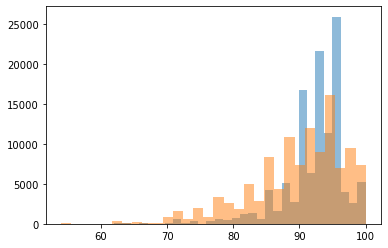

In [ ]:
plt.hist(loaded_model.predict(X_test),bins=30,alpha=0.5)
plt.hist(y_test,bins=30,alpha=0.5)

## average over business reviews

In [59]:
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv')
# df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

In [60]:
reviews = np.array(df['text'])
scores = np.array(df['Score'])
X, y = reviews, scores
# round
roundby = 1
y = np.array(list(map(lambda x: math.ceil(x / roundby) * roundby,y)))

In [98]:
# load in feature transforms
filename = model_directory + 'individual_review_features.pkl'
loaded_features = pkl.load(open(filename, 'rb'))
# load in model
filename = model_directory + 'individual_review_model.pkl'
loaded_model = pkl.load(open(filename, 'rb'))

In [99]:
good_reviews = np.array([r"They have some of the best seafood I've ever eaten here in Austin. I usually always order the same thing, but it never fails to be delicious. Their employees are all very nice too. They're clean, and the service is always quick, while never feeling rushed.",
                         r"We ordered the shrimp and oyster platter, broiled snapper plate and oysters diablos. Everything was delish but them oysters diablos were the bomb.com. We recommend ordering them every time. Service was good. The restaurant was clean.",
                         r"Great food, great service, great prices! It's hard to believe it's the same place that some of the negative reviews are referring to. Seafood is always fresh and the beer is always cold!",
                         r"Was undecided about going based on some reviews but decided to give it a try and so glad we did. Seafood was made to order and came out hot and fresh.  Service was very good. Food was very good. Price was very reasonable. I recommend and will be back.",
                         r"Very good food.  We had the shrimp poboy and there was shrimp in every bite.  The bun was freshly baked which only enhanced the taste.  The gumbo was delicious too.  The atmosphere is warm and friendly and the people are super friendly.  All in all, a positive dining experience.  I will return.",
                         r"The interior was very clean and had yummy aromas circulating.  I can definitely see why there is a 'sports-bar' vibe mentioned in some of the reviews.  Two TVs going, both with sports, lots of men with beer sitting around the central bar.  I think i was the only female in the place. The daily special was grilled flounder with a crab-shrimp brandy cream sauce.  Very, very tasty.  My son ordered this, and i swiped a bite of the fish, and two bites of the most excellent grilled veggies on the side.  Large platter, fitting the price.  I'd eat a veggie plate, if the grilled squash/onions/zucchini/mushrooms were the star!",
                         r"Amazing! Very fresh, and they tasted good too. I did douse them with lemon, a little seafood sauce, and Tabasco sauce though.  I also washed them down with my ice cold beer!  If you an get past the texture, you'll be ok. There was no shortage of saltine crackers. I did see someone with a large shrimp cocktail that I would like to try next time. Overall a very good experience. When my raw oyster on the half shell craving returns, I will be back to this place to satisfy it."
                        ])

In [100]:
bad_reviews = np.array([r"This place was absolutely disgusting. We considered turning around as soon as we walked in as it had an odd vibe, unpleasant smell and almost no customers. BUT I've been to my fair share of decent dive type spots so we decided we'd stick around and give it a chance. The sweet tea was great, but all of the food was inedible. Clearly frozen calamari tasted like fried rubber bands with several of the pieces looking questionable and moldy. The fried catfish looked like cafeteria/hospital food. It too was obviously just frozen (freezer burned) catfish they threw in the fryer along with kindergarten crinkle fries and crunchy hush puppies. I honestly couldn't even eat my food both because it was gross and in fear of getting sick. I forced myself to throw up as soon as I got home and I wish I was kidding. The worst part is that the bill was $40 for two entrees and and appetizer which is absolutely insane considering the quality of what they put in front of us. I wish I'd gone to Long John Silvers on my way in the parking lot instead. I absolutely do not recommend this place whatsoever.",
                         r"Horrible service, dirty facility; I gave them 2 stars because the catfish nuggets were pretty good and the wine was cold. When asking for the check; our server asked my husband to write down everything we ordered so he could create a receipt; I'm still confused by this because no one else at our table had to do that. Weird anyway; I'll never go back there.",
                         r"We came on a Friday evening and parking lot was full so it seemed promising however we were clearly mistaken. The dining room is fairly small and we were able to snag a table by the entrance. The table had not wiped down so there was still water rings and food crumbs from the previous person. We wiped down the table ourselves and waited for our server. 10 mins later no one came by the table. No one even looked in our direction. Was this a walk up to the bar and order yourself place? Who knows. There was what appeared to be a waitress offering menus to other tables. We left without even having anything so we can't comment on the food but unfortunately we won't be returning.",
                         r"Literally the most disgusting restaurant experience I've ever had. First of all our server did NOT wear a mask. She was rude as hell and downright didn't even know the menu. The food that came out was over cooked flounder that we didn't even eat. Actually spit the food into my napkin. Wouldn't wish this place on my worst enemy.",
                         r"Let me start w ordering. I ordered online. Got to the place to pick up my food then bam... my order wasn't ready. They couldn't even find my order. They thought I placed it for another location. Had to show from my phone I placed to round rock location. The guy had to call someone to get my online order. Had to wait an extra 30 min. Place was crowded and big groups of families in there. The food was ok. I wasn't that impressed. I got it to go bc I don't eat in restaurants due to Covid. So by the time I made it home it tasted old. Kind of stale. Like the grease the food was fried in was not fresh. Can't say I'll be back",
                         r"Expected more. Seemed dingy. Not very clean overall. Service was not up to par. They seemed to be more focus on serving those at the bar then at the tables. Our table was dirty, sticky. Menu was disgusting to the touch. The food was okay. Will not go again.",
                         r"Oysters on the half were good, kinda hard to mess them up. Wife ordered broiled rainbow trout, the fish was spoiled! You could smell it once the waitress set it on the table, so either their cook has no sense of smell or they just dont care if they make someone sick. The wait staff spends more time at the bar playing on their phones than they do waiting on customers. They did wear mask but there was no social distance between tables or at the bar. Speaking of the bar, it's very loud to the point you cannot have a conversation at your table. We will definitely never go back to this place and I would not recommend it anyone else  either.",
                         r"They failed health inspection with a score of 37 on December 10th, 2019. Report stated too many cockroaches to count and had rat feces in the dish area",
                         r"This place was absolutely disgusting. We considered turning around as soon as we walked in as it had an odd vibe, unpleasant smell and almost no customers. BUT I've been to my fair share of decent dive type spots so we decided we'd stick around and give it a chance. The sweet tea was great, but all of the food was inedible. Clearly frozen calamari tasted like fried rubber bands with several of the pieces looking questionable and moldy. The fried catfish looked like cafeteria/hospital food. It too was obviously just frozen (freezer burned) catfish they threw in the fryer along with kindergarten crinkle fries and crunchy hush puppies. I honestly couldn't even eat my food both because it was gross and in fear of getting sick. I forced myself to throw up as soon as I got home and I wish I was kidding. The worst part is that the bill was $40 for two entrees and and appetizer which is absolutely insane considering the quality of what they put in front of us. I wish I'd gone to Long John Silvers on my way in the parking lot instead. I absolutely do not recommend this place whatsoever."
                         r"I came here on Friday night with my family for dinner, this place is severely understaffed. And for that reason I can't find it in me to come back. All the waitstaff is running around stressing out and it shows in the quality of the food and service. It look 10 min to get greeted and welcomed, we ordered a app which came out after the food. My boyfriend ordered the crawfish that had a awful taste and smell, I ordered a shrimp salad which came with brown slimy lettuce a half of a slice of tomato and ranch dressing for 12.99 the menu said it was supposed to include more veggies so i asked for the side i was brought that and then noticed how old the lettuce was. My sisters crab cakes tasted old and no flavor whatsoever. My son ordered the chicken tenders and fries as my 2 year old is eating his food we notice a long hair inside of his food we then decided to take our complaints to the manger which told us that they are understaffed and extremely busy..... I really hope the owner of this establishment can do what needs to be done to get this place in the right track. I'm giving 2 starts for potential but I won't be back... your better off going to razzoos down the street"
                       ])

In [101]:
test_out = loaded_features.transform(good_reviews)
np.mean(loaded_model.predict(test_out))

89.85714285714286

In [102]:
test_out = loaded_features.transform(bad_reviews)
np.mean(loaded_model.predict(test_out))

90.22222222222223

In [64]:
loaded_model.predict(test_out)

array([91, 95, 95, 94, 90, 90, 71])

In [261]:
%%time
X_out = loaded_features.transform(X)

Wall time: 1min 59s


In [276]:
y_predict = loaded_model.predict(X_out)

In [292]:
y_predict = regressor.predict(X_out)

In [293]:
from sklearn.metrics import r2_score
r2_score(y, y_predict)

0.12243127750389315

In [294]:
df['predicted_score'] = y_predict

In [306]:
new_df = df.groupby(['business_id']).agg({'Score':'mean','predicted_score':'mean','review_stars':'mean'}).reset_index()

In [307]:
df['Score'].values

array([76., 76., 76., ..., 73., 73., 85.])

In [308]:
sklearn.metrics.r2_score(new_df['Score'].values,new_df['predicted_score'].values)

0.20016462378158562

(array([  3.,   2.,  10.,  12.,  16.,  40.,  35.,  58.,  82., 180., 237.,
        368., 482., 307., 353., 203.,  76.,  26.,   9.,   7.]),
 array([81.53266138, 82.24207659, 82.9514918 , 83.66090701, 84.37032222,
        85.07973743, 85.78915264, 86.49856785, 87.20798306, 87.91739826,
        88.62681347, 89.33622868, 90.04564389, 90.7550591 , 91.46447431,
        92.17388952, 92.88330473, 93.59271994, 94.30213515, 95.01155036,
        95.72096556]),
 <BarContainer object of 20 artists>)

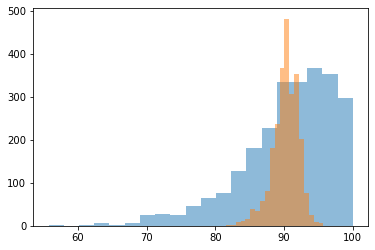

In [309]:
plt.hist(new_df.Score,bins=20,alpha=0.5)
plt.hist(new_df.predicted_score,bins=20,alpha=0.5)

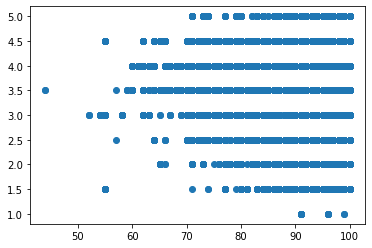

In [310]:
plt.scatter(df['Score'],df['stars'])
plt.show()

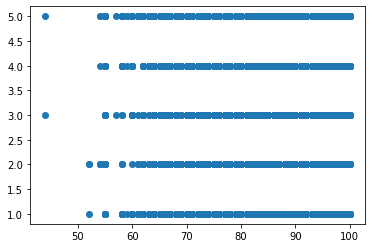

In [311]:
plt.scatter(df['Score'],df['review_stars'])
plt.show()

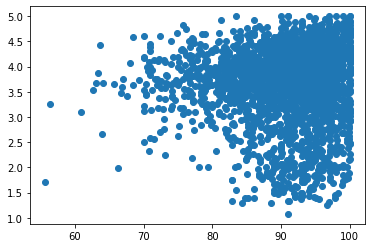

In [312]:
plt.scatter(new_df['Score'],new_df['review_stars'])
plt.show()

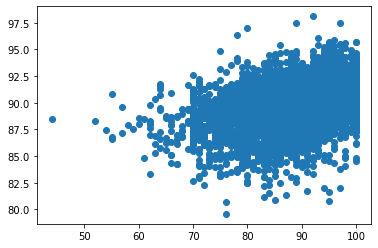

In [301]:
plt.scatter(new_df['Score'],new_df['predicted_score'])
plt.show()

## whole thing

In [322]:
business_id = 'NRPemqVb4qpWFF0Avq_6OQ'

In [7]:
yelp_api = YelpAPI(api_key, timeout_s=3.0)

In [323]:
response = yelp_api.reviews_query(id=business_id)

In [331]:
response['reviews'][0]['text']

"I've been going here for years - in person or curbside. Always big portions, hot food, and delicious! \n\nThey have a special on wine once a week, which I'm..."

In [11]:
name = 'Pacific Star Restaurant and Oyster Bar'
address = '351 W Palm Valley Blvd'

In [12]:
response = yelp_api.business_match_query(name=name,
                                         address1=address,
                                         city='Austin',
                                         state='TX',
                                         country='US')

In [16]:
response

{'businesses': [{'id': 'ZgOkZRqPqkGKhjSEXwIWFg',
   'alias': 'pacific-star-restaurant-and-oyster-bar-round-rock-3',
   'name': 'Pacific Star Restaurant & Oyster Bar',
   'coordinates': {'latitude': 30.51756, 'longitude': -97.68379},
   'location': {'address1': '351 W Palm Valley Blvd',
    'address2': '',
    'address3': '',
    'city': 'Round Rock',
    'zip_code': '78664',
    'country': 'US',
    'state': 'TX',
    'display_address': ['351 W Palm Valley Blvd', 'Round Rock, TX 78664']},
   'phone': '+15122553535',
   'display_phone': '(512) 255-3535'}]}

In [32]:
response_name = response['businesses'][0]['name']
print(f'Business found: {response_name}')
bid = response['businesses'][0]['id']
# yelp API doesn't give review full text yet
# reviews = yelp_api.reviews_query(id=bid)
reviews = df[df['business_id'] == bid]

Business found: Pacific Star Restaurant & Oyster Bar


In [33]:
reviews

,business_id,review_id,text,date,review_stars,Score,stars


In [27]:
df[df.business_id == bid]

,business_id,review_id,text,date,review_stars,Score,stars


## word2vec

In [163]:
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv')
# df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

In [162]:
reviews = np.array(df['text'])
scores = np.array(df['Score'])
cutoff = -1
X, y = reviews[:cutoff], scores[:cutoff]
# round
roundby = 1
y = np.array(list(map(lambda x: math.ceil(x / roundby) * roundby,y)))

4184/570613 (0.7332465261043825%) are fractional scores


# other feature engineering

## sentiment analysis

Let's see if running existing sentiment analysis functions can help us at all. In the long run, we want to make a custom sentiment analysis specifically for cleanliness, but we don't have the data to train that on.

In [176]:
from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

import nltk
nltk.download(['averaged_perceptron_tagger', 'punkt', 'vader_lexicon'])
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

from textblob import TextBlob

def sentiment_analysis_spacy(text):
    return (nlp(text))._.blob.polarity
def sentiment_analysis_nltk(text):
    return sia.polarity_scores(text)['compound']
def sentiment_analysis_tb(text):
    return TextBlob(text).sentiment.polarity

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Here are some reviews I got from a gross restaurant: https://www.yelp.com/biz/pacific-star-restaurant-and-oyster-bar-round-rock-3

I expect the bad reviews to be rated pretty lowly. I don't really care about the analysis on the good reviews.

In [177]:
good_reviews = [r"They have some of the best seafood I've ever eaten here in Austin. I usually always order the same thing, but it never fails to be delicious. Their employees are all very nice too. They're clean, and the service is always quick, while never feeling rushed.",
                r"We ordered the shrimp and oyster platter, broiled snapper plate and oysters diablos. Everything was delish but them oysters diablos were the bomb.com. We recommend ordering them every time. Service was good. The restaurant was clean.",
                r"Great food, great service, great prices! It's hard to believe it's the same place that some of the negative reviews are referring to. Seafood is always fresh and the beer is always cold!",
                r"Was undecided about going based on some reviews but decided to give it a try and so glad we did. Seafood was made to order and came out hot and fresh.  Service was very good. Food was very good. Price was very reasonable. I recommend and will be back.",
                r"Very good food.  We had the shrimp poboy and there was shrimp in every bite.  The bun was freshly baked which only enhanced the taste.  The gumbo was delicious too.  The atmosphere is warm and friendly and the people are super friendly.  All in all, a positive dining experience.  I will return.",
                r"The interior was very clean and had yummy aromas circulating.  I can definitely see why there is a 'sports-bar' vibe mentioned in some of the reviews.  Two TVs going, both with sports, lots of men with beer sitting around the central bar.  I think i was the only female in the place. The daily special was grilled flounder with a crab-shrimp brandy cream sauce.  Very, very tasty.  My son ordered this, and i swiped a bite of the fish, and two bites of the most excellent grilled veggies on the side.  Large platter, fitting the price.  I'd eat a veggie plate, if the grilled squash/onions/zucchini/mushrooms were the star!",
                r"Amazing! Very fresh, and they tasted good too. I did douse them with lemon, a little seafood sauce, and Tabasco sauce though.  I also washed them down with my ice cold beer!  If you an get past the texture, you'll be ok. There was no shortage of saltine crackers. I did see someone with a large shrimp cocktail that I would like to try next time. Overall a very good experience. When my raw oyster on the half shell craving returns, I will be back to this place to satisfy it."
               ]

In [194]:
bad_reviews = [r"This place was absolutely disgusting. We considered turning around as soon as we walked in as it had an odd vibe, unpleasant smell and almost no customers. BUT I've been to my fair share of decent dive type spots so we decided we'd stick around and give it a chance. The sweet tea was great, but all of the food was inedible. Clearly frozen calamari tasted like fried rubber bands with several of the pieces looking questionable and moldy. The fried catfish looked like cafeteria/hospital food. It too was obviously just frozen (freezer burned) catfish they threw in the fryer along with kindergarten crinkle fries and crunchy hush puppies. I honestly couldn't even eat my food both because it was gross and in fear of getting sick. I forced myself to throw up as soon as I got home and I wish I was kidding. The worst part is that the bill was $40 for two entrees and and appetizer which is absolutely insane considering the quality of what they put in front of us. I wish I'd gone to Long John Silvers on my way in the parking lot instead. I absolutely do not recommend this place whatsoever.",
               r"Horrible service, dirty facility; I gave them 2 stars because the catfish nuggets were pretty good and the wine was cold. When asking for the check; our server asked my husband to write down everything we ordered so he could create a receipt; I'm still confused by this because no one else at our table had to do that. Weird anyway; I'll never go back there.",
               r"We came on a Friday evening and parking lot was full so it seemed promising however we were clearly mistaken. The dining room is fairly small and we were able to snag a table by the entrance. The table had not wiped down so there was still water rings and food crumbs from the previous person. We wiped down the table ourselves and waited for our server. 10 mins later no one came by the table. No one even looked in our direction. Was this a walk up to the bar and order yourself place? Who knows. There was what appeared to be a waitress offering menus to other tables. We left without even having anything so we can't comment on the food but unfortunately we won't be returning.",
               r"Literally the most disgusting restaurant experience I've ever had. First of all our server did NOT wear a mask. She was rude as hell and downright didn't even know the menu. The food that came out was over cooked flounder that we didn't even eat. Actually spit the food into my napkin. Wouldn't wish this place on my worst enemy.",
               r"Let me start w ordering. I ordered online. Got to the place to pick up my food then bam... my order wasn't ready. They couldn't even find my order. They thought I placed it for another location. Had to show from my phone I placed to round rock location. The guy had to call someone to get my online order. Had to wait an extra 30 min. Place was crowded and big groups of families in there. The food was ok. I wasn't that impressed. I got it to go bc I don't eat in restaurants due to Covid. So by the time I made it home it tasted old. Kind of stale. Like the grease the food was fried in was not fresh. Can't say I'll be back",
               r"Expected more. Seemed dingy. Not very clean overall. Service was not up to par. They seemed to be more focus on serving those at the bar then at the tables. Our table was dirty, sticky. Menu was disgusting to the touch. The food was okay. Will not go again.",
               r"Oysters on the half were good, kinda hard to mess them up. Wife ordered broiled rainbow trout, the fish was spoiled! You could smell it once the waitress set it on the table, so either their cook has no sense of smell or they just dont care if they make someone sick. The wait staff spends more time at the bar playing on their phones than they do waiting on customers. They did wear mask but there was no social distance between tables or at the bar. Speaking of the bar, it's very loud to the point you cannot have a conversation at your table. We will definitely never go back to this place and I would not recommend it anyone else  either.",
               r"They failed health inspection with a score of 37 on December 10th, 2019. Report stated too many cockroaches to count and had rat feces in the dish area",
               r"I came here on Friday night with my family for dinner, this place is severely understaffed. And for that reason I can't find it in me to come back. All the waitstaff is running around stressing out and it shows in the quality of the food and service. It look 10 min to get greeted and welcomed, we ordered a app which came out after the food. My boyfriend ordered the crawfish that had a awful taste and smell, I ordered a shrimp salad which came with brown slimy lettuce a half of a slice of tomato and ranch dressing for 12.99 the menu said it was supposed to include more veggies so i asked for the side i was brought that and then noticed how old the lettuce was. My sisters crab cakes tasted old and no flavor whatsoever. My son ordered the chicken tenders and fries as my 2 year old is eating his food we notice a long hair inside of his food we then decided to take our complaints to the manger which told us that they are understaffed and extremely busy..... I really hope the owner of this establishment can do what needs to be done to get this place in the right track. I'm giving 2 starts for potential but I won't be back... your better off going to razzoos down the street"
              ]

In [195]:
bad_review_df = pd.DataFrame({
    'spacy':list(map(sentiment_analysis_spacy, bad_reviews)),
    'nltk':list(map(sentiment_analysis_nltk, bad_reviews)),
    'textblob':list(map(sentiment_analysis_tb, bad_reviews))
})
# function to highlight negative values
def highlight_sign(s):
    if s.dtype == object:
        is_neg = [False for _ in range(s.shape[0])]
    else:
        is_neg = s < 0
    return ['color: red;' if cell else 'color:white' 
            for cell in is_neg]
bad_review_df.style.apply(highlight_sign)

,spacy,nltk,textblob
0,-0.145489,0.190100,-0.145489
1,-0.256173,-0.483000,-0.256173
2,-0.016898,-0.497000,-0.016898
3,-0.258333,-0.968800,-0.258333
4,0.118750,-0.232500,0.118750
5,-0.042628,-0.783000,-0.042628
6,-0.008671,-0.624000,-0.008671
7,0.000000,-0.510600,0.000000
8,-0.005407,0.481600,-0.005407


In [189]:
bad_review_df = pd.DataFrame({
    'spacy':list(map(sentiment_analysis_spacy, bad_reviews)),
    'nltk':list(map(sentiment_analysis_nltk, bad_reviews)),
    'textblob':list(map(sentiment_analysis_tb, bad_reviews))
})
# function to highlight negative values
def highlight_sign(s):
    if s.dtype == object:
        is_neg = [False for _ in range(s.shape[0])]
    else:
        is_neg = s < 0
    return ['color: red;' if cell else 'color:white' 
            for cell in is_neg]
bad_review_df.style.apply(highlight_sign)

,spacy,nltk,textblob
0,-0.145489,0.190100,-0.145489
1,-0.256173,-0.483000,-0.256173
2,-0.016898,-0.497000,-0.016898
3,-0.258333,-0.968800,-0.258333
4,0.118750,-0.232500,0.118750
5,-0.042628,-0.783000,-0.042628
6,-0.008671,-0.624000,-0.008671
7,0.000000,-0.510600,0.000000
8,-0.081451,0.435700,-0.081451


In [185]:
good_review_df = pd.DataFrame({
    'spacy':list(map(sentiment_analysis_spacy, good_reviews)),
    'nltk':list(map(sentiment_analysis_nltk, good_reviews)),
    'textblob':list(map(sentiment_analysis_tb, good_reviews))
})
good_review_df.style.apply(highlight_sign)

,spacy,nltk,textblob
0,0.435000,0.957000,0.435000
1,0.533333,0.892200,0.533333
2,0.194792,0.901800,0.194792
3,0.447143,0.968400,0.447143
4,0.457845,0.970900,0.457845
5,0.286091,0.944000,0.286091
6,0.114920,0.945800,0.114920


So textblob and spacytextblob are the same thing, but textblob runs a lot faster. nltk and tb give different answers, though, and these are some really negative reviews. It seems that nltk fails on the first/last reviews which are long whereas tb can't tell about reviews 4 and 7 which makes sense, reading them. Going with textblob.

In [198]:
%%time
df['text'][:10000].apply(sentiment_analysis_tb)

Wall time: 13.3 s


0       0.298052
1       0.466558
2       0.790625
3       0.409615
4       0.461540
          ...   
9995    0.143333
9996    0.052778
9997    0.700000
9998    0.475000
9999    0.550000
Name: text, Length: 10000, dtype: float64

In [202]:
print(f"running this will take {len(df) * 13.3/10000 /60} minutes")

running this will take 12.648610333333332 minutes


In [203]:
df['sentiment'] = df['text'].apply(sentiment_analysis_tb)

In [ ]:
df['review_stars']

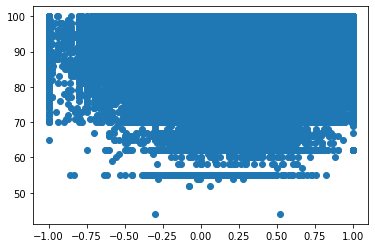

In [212]:
plt.scatter(df.sentiment,df.Score)

In [296]:
def percent_bad_reviews(values):
    return sum(values < 0.25)/len(values)

In [292]:
grouped = df.groupby('business_id')
new_df = grouped.agg(sentiment=('sentiment','mean'),
                     percent_bad_sentiment=('sentiment',percent_bad_reviews),
                     Score=('Score','mean'),
                     review_stars=('review_stars','mean')
                    ).reset_index()

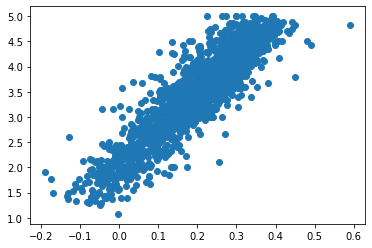

In [287]:
# obvious correlation with review stars
plt.scatter(new_df.sentiment,new_df.review_stars)

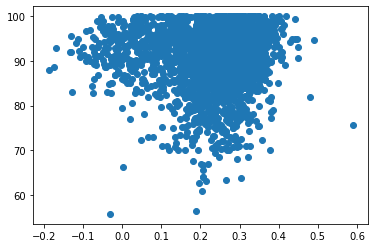

In [288]:
# not much correlation with Score with a straight average
plt.scatter(new_df.sentiment,new_df.Score)

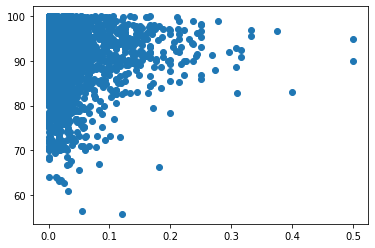

In [297]:
# not much correlation with % bad reviews
plt.scatter(new_df.percent_bad_sentiment,new_df.Score)

## DIRTY_WORDS

Gathering a corpus to describe dirty restaurants from reddit posts by health inspectors talking about their worst ever experiences:
* https://www.reddit.com/r/AskReddit/comments/1lnddh/health_inspectors_of_reddit_what_is_the_worst/
* https://www.reddit.com/r/AskReddit/comments/2h1uuq/food_inspectors_of_reddit_whats_the_worst/

Following this helpful guide: https://towardsdatascience.com/scraping-reddit-data-1c0af3040768

And this post: https://stackoverflow.com/questions/60623349/how-to-limit-first-level-comments-in-praw-reddit

In [328]:
import praw
from praw.models import MoreComments
f = open(data_directory + 'reddit_api_key.txt','r')
r_client_id, r_secret, r_user_agent = [line.strip() for line in f.readlines()]
f.close()
reddit = praw.Reddit(client_id=r_client_id, client_secret=r_secret, user_agent=r_user_agent)

In [411]:
# get all top-level comments in a post
def iter_top_level(comments):
    for top_level_comment in comments:
        if isinstance(top_level_comment, MoreComments):
            yield from iter_top_level(top_level_comment.comments())
        else:
            yield top_level_comment

def get_reddit_comments(post_id="1lnddh"):
    submission = reddit.submission(post_id)
    comments = []
    for comment in iter_top_level(submission.comments): 
        # only get NON-deleted posts with >5 score
        if comment.author and comment.score > 5:
            comments.append(comment.body)
    return comments

In [413]:
%%time
comments = []
post_ids = ["1lnddh","2h1uuq","598qrb"]
for i in post_ids:
    comments += get_reddit_comments(i)

Wall time: 56.3 s


In [414]:
len(comments)

229

In [ ]:
TdidfVectorizer

In [378]:
filename = processed_data_directory + 'reddit_comments.csv'
f

In [409]:
comment.score

1

In [407]:
comment = submission.comments[-2]

In [402]:
if comment.author and comment.score > 5:
    print('ok')

ok


In [404]:
comments[-3].score

AttributeError: 'str' object has no attribute 'score'

In [358]:
comments = get_reddit_comments("1lnddh")

In [368]:
comments[4]

'[deleted]'

In [372]:
if submission.comments[4].author:
    print('ok')

In [360]:
comments[1]

"Going on 10 years as an inspector.  Most dangerous is usually not the most disgusting.  I've seen entire walk in coolers they were using at 55-60°F and the staff didn't even notice anything wrong.  I've seen piles of mice that died getting stuck in the grease behind the fryer.  I've seen staff throwing raw burgers on the grill then making a salad right after.  I've seen squirrels and birds roaming freely inside a bread manufacturer.  The stereotypes are true, Chinese restaurant kitchens are almost always filthy.\n\nMost common critical violation:  Dish machine not sanitizing properly."

In [321]:
comments = []
post_ids = ["1lnddh","2h1uuq","598qrb"]

In [336]:
submission = reddit.submission(id="1lnddh")
len(submission.comments)

45

In [340]:
submission.comments[44].children

['cc0wxqj',
 'cc14rnq',
 'cc14uw7',
 'cc186x4',
 'cc0wx0n',
 'cc17j0t',
 'cc1f0r5',
 'cc19aw8',
 'cc14mvx',
 'cc0zv27']

In [335]:
len(out)

44

In [316]:
submission = reddit.submission(id="2h1uuq")
submission.comments.replace_more(limit=0)
comments = [comment.body for comment in submission.comments]

In [317]:
len(comments)

41

In [417]:
comments[0]

"Environmental Health Inspectors don't only cover restaurants.  I inspect wells and septic systems.  I see sewage everyday.  The worst thing I've seen are old men coming up to their door naked . . . and what makes it worse is that they knew what date and time I was stopping by."

In [434]:
doc = nlp(comments[0])

In [439]:
[t.lemma_ for t in doc]

['Environmental',
 'Health',
 'Inspectors',
 'do',
 'not',
 'only',
 'cover',
 'restaurant',
 '.',
 ' ',
 'I',
 'inspect',
 'well',
 'and',
 'septic',
 'system',
 '.',
 ' ',
 'I',
 'see',
 'sewage',
 'everyday',
 '.',
 ' ',
 'the',
 'bad',
 'thing',
 'I',
 "'ve",
 'see',
 'be',
 'old',
 'man',
 'come',
 'up',
 'to',
 'their',
 'door',
 'naked',
 '.',
 '.',
 '.',
 'and',
 'what',
 'make',
 'it',
 'bad',
 'be',
 'that',
 'they',
 'know',
 'what',
 'date',
 'and',
 'time',
 'I',
 'be',
 'stop',
 'by',
 '.']

In [431]:
# simple bag of words
tfidf = TfidfVectorizer(tokenizer = ,
                        min_df=2, max_df=0.99, max_features=2000,
                        ngram_range=(1,1), stop_words=STOP_WORDS)

In [432]:
tfed = tfidf.fit_transform(np.array(comments))

In [433]:
# looking at high tf-idf terms
high_value_terms = dict(zip(tfidf.vocabulary_, tfidf.idf_))
high_value_terms = dict(sorted(high_value_terms.items(), key=lambda item: item[1],reverse=True))
high_value_terms

{'inspectors': 5.339467020255086,
 'don': 5.339467020255086,
 'wells': 5.339467020255086,
 'septic': 5.339467020255086,
 'sewage': 5.339467020255086,
 'everyday': 5.339467020255086,
 'old': 5.339467020255086,
 'men': 5.339467020255086,
 'coming': 5.339467020255086,
 'door': 5.339467020255086,
 'makes': 5.339467020255086,
 'knew': 5.339467020255086,
 '10': 5.339467020255086,
 'years': 5.339467020255086,
 'inspector': 5.339467020255086,
 'usually': 5.339467020255086,
 '55': 5.339467020255086,
 'staff': 5.339467020255086,
 'piles': 5.339467020255086,
 'burgers': 5.339467020255086,
 'making': 5.339467020255086,
 'salad': 5.339467020255086,
 'squirrels': 5.339467020255086,
 'roaming': 5.339467020255086,
 'manufacturer': 5.339467020255086,
 'kitchens': 5.339467020255086,
 'filthy': 5.339467020255086,
 'common': 5.339467020255086,
 'violation': 5.339467020255086,
 'dish': 5.339467020255086,
 'sanitizing': 5.339467020255086,
 'kitchen': 5.339467020255086,
 'told': 5.339467020255086,
 'shut': 5